# Quante persone saranno contagiate?

Si vedono tante proiezioni sui contagiati, tutte fanno vedere una curva esponenziale (che shizza verso l'alto).
Questo effetto piuttosto drammatico è dato più dalla scelta del modello statistico che dai dati in sè.

In questo notebook confrontiamo il modello esponenziale con un modello più sobrio, che tiene conto del più comune andamento dei fenomeni biologici: cioè una rapida crescita seguita da un assestamento. Faremo anche una predizione su quando avverrà questo assestamento.

Per cominciare importiamo le librerie, carichiamo i dati e facciamo una pulizia.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lmfit import Model

df = pd.read_csv('./../publication/provinceArchivioISTAT.csv')
df = df.dropna()
df.sample(5)


,provincia,numero,regione,datetime,codiceISTAT
52,Torino,19.0,PIEMONTE,2020-03-05,201.0
14,Piacenza,378.0,EMILIA-ROMAGNA,2020-03-05,33.0
171,VICENZA,10.0,VENETO,2020-03-04,24.0
254,Reggio Emilia,8.0,EMILIA-ROMAGNA,2020-03-02,35.0
124,Milano,145.0,LOMBARDIA,2020-03-04,215.0


Prendiamo in esame i malati cumulativi in base ai giorni.

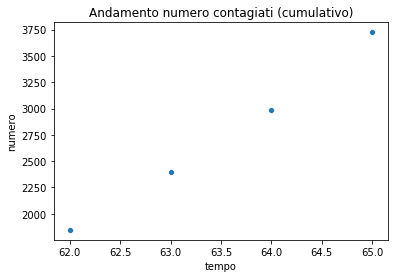

In [2]:
# semplifichiamo le date usando il giorno dell'anno ( da 0 a 365 )
df['tempo'] = df['datetime'].map( lambda d: pd.to_datetime(d).timetuple().tm_yday )

# raggruppa in base al giorno
df_by_datetime = df[ ['datetime', 'tempo', 'numero'] ].groupby('tempo')
df_by_datetime = df_by_datetime.sum().sort_values(by='tempo')
df_by_datetime = df_by_datetime.reset_index()

# contagi cumulativi
g = sns.scatterplot(data=df_by_datetime, x='tempo', y='numero')
g.set_title('Andamento numero contagiati (cumulativo)')
plt.show()

Definiamo tre modelli diversi
- linea
- esponente
- sigmoide

In [6]:
def line(x, a, b, c):
    return x*a + b
line_init_params = { 'a': 2, 'b': 1, 'c':0 }

def exponent(x, a, b, c):
    return (x**a) * b + c
exp_init_params = { 'a': 2, 'b': 1, 'c':0 }

def sigmoid(x, a, b, c):
    expo = a * (b - x)
    sig = 1 / ( 1 + np.exp( expo ) ) * c
    return sig
sig_init_params = { 'a': 0.001, 'b': 500, 'c':4000 }

all_models_and_initial_params = [
    [line, line_init_params],
    [exponent, exp_init_params],
    [sigmoid, sig_init_params]
]

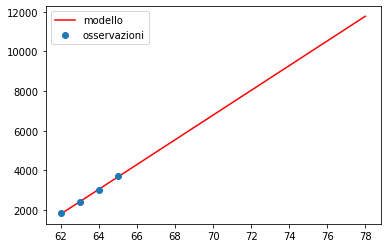

[[Model]]
    Model(line)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 4
    # variables        = 3
    chi-square         = 9241.00000
    reduced chi-square = 9241.00000
    Akaike info crit   = 36.9804441
    Bayesian info crit = 35.1393272
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a:  623.000000 (init = 2)
    b: -36821.5000 (init = 1)
    c:  0.00000000 (init = 0)


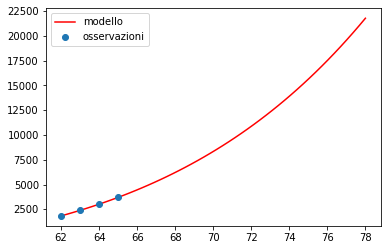

[[Model]]
    Model(exponent)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8002
    # data points      = 4
    # variables        = 3
    chi-square         = 1344.54185
    reduced chi-square = 1344.54185
    Akaike info crit   = 29.2700570
    Bayesian info crit = 27.4289400
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a:  7.38989387 (init = 2)
    b:  2.5436e-10 (init = 1)
    c: -2643.36168 (init = 0)


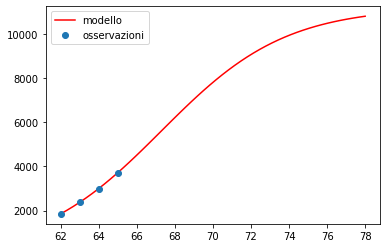

[[Model]]
    Model(sigmoid)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 283
    # data points      = 4
    # variables        = 3
    chi-square         = 471.568760
    reduced chi-square = 471.568760
    Akaike info crit   = 25.0790822
    Bayesian info crit = 23.2379653
[[Variables]]
    a:  0.30637352 +/- 0.03740880 (12.21%) (init = 0.001)
    b:  67.2875866 +/- 2.02243736 (3.01%) (init = 500)
    c:  11222.8404 +/- 4039.02801 (35.99%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, c) =  1.000
    C(a, b) = -0.994
    C(a, c) = -0.991


In [11]:
df_x = df_by_datetime['tempo'].values
df_y = df_by_datetime['numero'].values

for mod, init_params in all_models_and_initial_params:
    
    model  = Model(mod)
    result = model.fit( df_y, x=df_x, **init_params)
    
    all_year = np.linspace(np.min(df_x), np.max(df_x)*1.2)
    predictions = result.eval(x=all_year)
    plt.plot(all_year, predictions, 'r-', label='modello')
    plt.plot(df_x, df_y, 'o', label='osservazioni')
    plt.legend(loc='best')
    plt.show()
    
    print(result.fit_report())

    
    